In [1]:
#https://www.tensorflow.org/decision_forests/tutorials/automatic_tuning_colab

from google.cloud import bigquery
from datetime import date, timedelta, datetime 

import time

import pandas as pd
import numpy as np

import math
import os

import tensorflow as tf
print(tf.__version__)

2023-11-18 07:47:37.654567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.12.0


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
#pip install tensorflow_decision_forests --upgrade --user
import tensorflow_decision_forests as tfdf
print(tfdf.__version__)

1.4.0


# Variable to Configuration

In [3]:
model_tree_type=1# 1= xgboost  2-random forest
option_cate_feature=1  # 1=numberice hour 2. range hour

#labelCol='label_multi_severity'
labelCol='label_binary_severity'

metric="accuracy"

model_prefix="demo2_tuned"
bucket_name="gs://demo2-tf-incident-pongthorn"

In [4]:
projectId='pongthorn'
dataset_id='SMartML'

train_name='train2_incident'
test_name='test2_incident'

train_table_id=f"{projectId}.{dataset_id}.{train_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
print(f"train-ds = {train_table_id}")
print(f"test-ds = {test_tabel_id}")

train-ds = pongthorn.SMartML.train2_incident
test-ds = pongthorn.SMartML.test2_incident


In [5]:
if  labelCol=='label_multi_severity':
    if model_tree_type==1:
        _model=f'{model_prefix}_multi_gbt_tf_model'
    else:
         _model=f'{model_prefix}_multi_rf_tf__model'
else:
    if model_tree_type==1:
        _model=f'{model_prefix}_binary_gbt_tf_model'
    else:
         _model=f'{model_prefix}_binary_rf_tf_model'

if option_cate_feature==1:
    
    cateCols=['sla','product_type','brand','service_type','incident_type']
    numbericCols=['open_to_close_hour']
    if labelCol=='label_multi_severity':
     unusedCols=['id','severity_id','severity_name','range_open_to_close_hour','label_binary_severity']
    else:
      unusedCols=['id','severity_id','severity_name','range_open_to_close_hour','label_multi_severity']  
else:
    # cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour','range_response_to_resolved_hour']
    cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour']
    numbericCols=[]
    #unusedCols=['id','severity_id','severity_name','label_binary_severity','open_to_close_hour','response_to_resolved_hour']
    if labelCol=='label_multi_severity':
     unusedCols=['id','severity_id','severity_name','open_to_close_hour','label_binary_severity']
    else:
     unusedCols=['id','severity_id','severity_name','open_to_close_hour','label_multi_severity']   
    
    _model=f"{_model}_range_hour"
 


print(f"CateCols : {cateCols}")
print(f"NumbericCols : {numbericCols}")
print(f"UnusedCols : {unusedCols}")

model_gs_path=f"{bucket_name}/{_model}"
print(model_gs_path)
#model_local_path=_model

CateCols : ['sla', 'product_type', 'brand', 'service_type', 'incident_type']
NumbericCols : ['open_to_close_hour']
UnusedCols : ['id', 'severity_id', 'severity_name', 'range_open_to_close_hour', 'label_multi_severity']
gs://demo2-tf-incident-pongthorn/demo2_tuned_binary_gbt_tf_model


# Load & Prepare Data

In [6]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 
 return df

def load_data_bq(sql:str):
 
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
 df[labelCol]=df[labelCol].astype('int64') 
 df=df[[labelCol]+cateCols+numbericCols]   
  
 return df

In [7]:
client = bigquery.Client(project=projectId)

train=load_data_bq(f"SELECT * FROM {train_table_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")

print(train.info())

print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   label_binary_severity  3004 non-null   int64  
 1   sla                    3004 non-null   object 
 2   product_type           3004 non-null   object 
 3   brand                  3004 non-null   object 
 4   service_type           3004 non-null   object 
 5   incident_type          3004 non-null   object 
 6   open_to_close_hour     3004 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 164.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751 entries, 0 to 750
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   label_binary_severity  751 non-null    int64  
 1   sla                    751 non-null    object 
 2   product_type           751 non-null    o

In [8]:
classes_train = list(train[labelCol].unique())
classes_test = list(test[labelCol].unique())

set_classes=set(classes_train) & set(classes_test)
classes=list(set_classes)
classes

[0, 1]

In [9]:
train.tail(5)
# train.to_csv("train_tfdf.csv",index=False)

,label_binary_severity,sla,product_type,brand,service_type,incident_type,open_to_close_hour
2999,1,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,306.583333
3000,1,24x7 4Hrs Response Time,Software,Trend Micro,Incident,General Incident,2247.850000
3001,1,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,21.883333
3002,1,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,Configuration Change,119.616667
3003,1,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,13.316667


In [10]:
test.tail()
# test.to_csv("test_tfdf.csv",index=False)

,label_binary_severity,sla,product_type,brand,service_type,incident_type,open_to_close_hour
746,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,Software,0.650000
747,0,24x7 4Hrs Response Time,Software,Trend Micro,Incident,General Incident,16.983333
748,0,24x7 4Hrs Response Time,Software,Trend Micro,Incident,Software,289.683333
749,0,24x7 4Hrs Response Time,Software,Trend Micro,Incident,Software,28.550000
750,1,24x7 4Hrs Response Time,Security,Trend Micro,Incident,Software,51.166667


# Convert dataframe to tensorflow dataset

In [11]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=labelCol)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label=labelCol)

# Tune Model

## Training a model with automated hyper-parameter tuning and automatic definition of the hyper-parameters (recommended approach)

As before, hyper-parameter tuning is enabled by specifying the tuner constructor argument of the model. Set use_predefined_hps=True to automatically configure the search space for the hyper-parameters.

In [12]:
import time

t_Start=time.time()

print(f"Start tund at {datetime.now()}")

Start tund at 2023-11-18 07:47:48.938936


In [13]:
#https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/tuner/RandomSearch
tuner = tfdf.tuner.RandomSearch( use_predefined_hps=True)

# Specify the model.
if model_tree_type==1:
    print("GradientBoostedTreesModel")
    tuned_model=tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
else:
    print("RandomForestModel")
    tuned_model = tfdf.keras.RandomForestModel(tuner=tuner)

tuned_model.fit(x=train_ds,verbose=2)

GradientBoostedTreesModel
Use /var/tmp/tmpaagmy4ng as temporary training directory
Reading training dataset...


[WARNING 23-11-18 07:47:50.2363 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-11-18 07:47:50.2377 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-11-18 07:47:50.2382 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-11-18 07:47:50.281085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [3004]
	 [[{{node Placeholder/_5}}]]


Training tensor examples:
Features: {'sla': <tf.Tensor 'data:0' shape=(None,) dtype=string>, 'product_type': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'brand': <tf.Tensor 'data_2:0' shape=(None,) dtype=string>, 'service_type': <tf.Tensor 'data_3:0' shape=(None,) dtype=string>, 'incident_type': <tf.Tensor 'data_4:0' shape=(None,) dtype=string>, 'open_to_close_hour': <tf.Tensor 'data_5:0' shape=(None,) dtype=float64>}
Label: Tensor("data_6:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'sla': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data:0' shape=(None,) dtype=string>), 'product_type': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_1:0' shape=(None,) dtype=string>), 'brand': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_2:0' shape=(None,) dtype=string>), 'service_type': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_3:0' shape=(None,) dty

[INFO 23-11-18 07:47:54.4086 UTC kernel.cc:773] Start Yggdrasil model training
[INFO 23-11-18 07:47:54.4086 UTC kernel.cc:774] Collect training examples
[INFO 23-11-18 07:47:54.4087 UTC kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-11-18 07:47:54.4090 UTC kernel.cc:393] Number of batches: 4
[INFO 23-11-18 07:47:54.4090 UTC kernel.cc:394] Number of examples: 3004
[INFO 23-11-18 07:47:54.4096 UTC data_spec_inference.cc:305] 10 item(s) have been pruned (i.e. they are considered out of dictionary) for the column brand (19 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO 23-11-18 07:47:54.4096 UTC data_spec_infere

Model trained in 0:01:12.274079
Compiling model...


2023-11-18 07:49:06.677538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [3004]
	 [[{{node Placeholder/_5}}]]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [14]:
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execution : ',round(t_elapsed,2)) 
print(datetime.now())

Total execution :  0.02
2023-11-18 07:49:16.276462


# Evaluate the model

In [16]:
rc_pc_thresholds=0.5
myMetrics=[tf.keras.metrics.BinaryAccuracy(threshold=rc_pc_thresholds)
           ,tf.keras.metrics.AUC()
           ,tf.keras.metrics.Precision(thresholds=rc_pc_thresholds)
           ,tf.keras.metrics.Recall(thresholds=rc_pc_thresholds)]

tuned_model.compile([myMetrics])
tuned_test_x_measure = tuned_model.evaluate(test_ds, return_dict=True, verbose=0)
for name, value in tuned_test_x_measure.items():
  print(f"{name}: {value:.4f}")


loss: 0.0000
binary_accuracy: 0.7870
auc_1: 0.8750
precision_1: 0.8068
recall_1: 0.7823


# Inspect and debug decision forest models
## Model structure and feature importance

In [21]:
# Display the tuning logs.
tuning_logs = tuned_model.make_inspector().tuning_logs()
tuning_logs.head(10)

,score,evaluation_time,best,split_axis,sparse_oblique_projection_density_factor,sparse_oblique_normalization,sparse_oblique_weights,categorical_algorithm,growing_strategy,max_num_nodes,sampling_method,subsample,shrinkage,min_examples,use_hessian_gain,num_candidate_attributes_ratio,max_depth
0,-0.808183,0.171256,False,SPARSE_OBLIQUE,5.0,MIN_MAX,BINARY,CART,BEST_FIRST_GLOBAL,32.0,RANDOM,1.0,0.10,10,false,0.2,NaN
1,-0.795893,1.221791,False,SPARSE_OBLIQUE,2.0,NONE,BINARY,RANDOM,BEST_FIRST_GLOBAL,128.0,RANDOM,0.8,0.02,10,true,0.9,NaN
2,-0.818458,1.579137,False,SPARSE_OBLIQUE,3.0,NONE,BINARY,RANDOM,LOCAL,NaN,RANDOM,1.0,0.10,5,false,0.5,8.0
3,-0.816619,1.745522,False,SPARSE_OBLIQUE,1.0,NONE,BINARY,CART,BEST_FIRST_GLOBAL,64.0,RANDOM,1.0,0.10,20,false,0.2,NaN
4,-0.785947,2.441085,True,SPARSE_OBLIQUE,4.0,STANDARD_DEVIATION,CONTINUOUS,RANDOM,BEST_FIRST_GLOBAL,256.0,RANDOM,1.0,0.10,20,true,0.5,NaN
5,-0.809973,4.449670,False,SPARSE_OBLIQUE,1.0,MIN_MAX,BINARY,RANDOM,BEST_FIRST_GLOBAL,32.0,RANDOM,0.6,0.02,20,false,1.0,NaN
6,-0.806562,5.430675,False,SPARSE_OBLIQUE,5.0,NONE,CONTINUOUS,RANDOM,BEST_FIRST_GLOBAL,256.0,RANDOM,0.8,0.05,5,false,0.5,NaN
7,-0.845030,5.632187,False,SPARSE_OBLIQUE,3.0,STANDARD_DEVIATION,CONTINUOUS,CART,LOCAL,NaN,RANDOM,0.8,0.10,7,false,0.9,4.0
8,-0.788027,6.213440,False,SPARSE_OBLIQUE,3.0,STANDARD_DEVIATION,CONTINUOUS,RANDOM,BEST_FIRST_GLOBAL,256.0,RANDOM,0.9,0.05,10,true,0.9,NaN
9,-0.792198,6.829639,False,SPARSE_OBLIQUE,5.0,STANDARD_DEVIATION,BINARY,RANDOM,LOCAL,NaN,RANDOM,0.9,0.05,20,true,0.9,8.0


In [91]:
# Best hyper-parameters.
tuning_logs[tuning_logs.best].iloc[0]

score                                                -0.785947
evaluation_time                                       2.323339
best                                                      True
split_axis                                      SPARSE_OBLIQUE
sparse_oblique_projection_density_factor                   4.0
sparse_oblique_normalization                STANDARD_DEVIATION
sparse_oblique_weights                              CONTINUOUS
categorical_algorithm                                   RANDOM
growing_strategy                             BEST_FIRST_GLOBAL
max_num_nodes                                            256.0
sampling_method                                         RANDOM
subsample                                                  1.0
shrinkage                                                  0.1
min_examples                                                20
use_hessian_gain                                          true
num_candidate_attributes_ratio                         

# Plotting the training logs

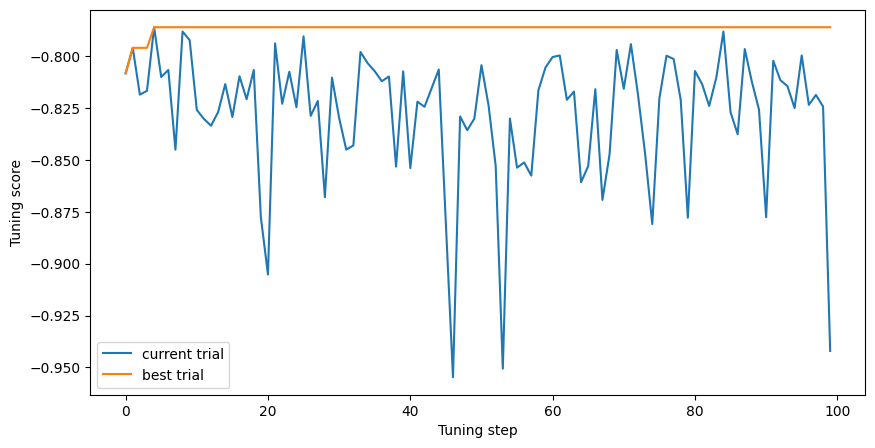

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(tuning_logs["score"], label="current trial")
plt.plot(tuning_logs["score"].cummax(), label="best trial")
plt.xlabel("Tuning step")
plt.ylabel("Tuning score")
plt.legend()
plt.show()

# Save Model

In [93]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/distribute/save_and_load.ipynb#scrollTo=jFcuzsI94bNA
#save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
# model.save(model_gs_path,options=save_options)
# model.save(model_local_path,options=save_options)
tuned_model.save(model_gs_path)

INFO:tensorflow:Assets written to: gs://demo2-tf-incident-pongthorn/demo2_tuned_binary_gbt_tf_model/assets


INFO:tensorflow:Assets written to: gs://demo2-tf-incident-pongthorn/demo2_tuned_binary_gbt_tf_model/assets
